In [6]:
import zipfile

In [7]:
import zipfile
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import(InceptionV3, MobileNetV2, DenseNet121, ResNet50, EfficientNetV2B0, Xception)
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, Activation, GlobalAveragePooling2D,DepthwiseConv2D, Input, Add, Concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from IPython.display import Image


In [8]:
!pip install tensorflow-addons==0.17.1
import tensorflow_addons as tfa

Try 3

In [5]:
zip_path = "/content/drive/MyDrive/Colab Notebooks/Lung Cancer dataset 1 /Copy of train.zip"  # Path to the ZIP file
extracted_path = "/content/chest_ctscan_images"  # Path to extract the files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

In [9]:
train_dir = os.path.join(extracted_path, "train")
valid_dir = "/content/chest_ctscan_images/valid"
test_dir = "/content/chest_ctscan_images/test"

In [10]:
# Create a validation set from a portion of the training set
def create_validation_set(source_dir, validation_dir, validation_ratio=0.2):
    if not os.path.exists(validation_dir):
        os.makedirs(validation_dir)

    for class_name in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_name)
        class_valid_path = os.path.join(validation_dir, class_name)

        if not os.path.exists(class_valid_path):
            os.makedirs(class_valid_path)

        all_files = os.listdir(class_source_path)
        train_files, valid_files = train_test_split(all_files, test_size=validation_ratio, random_state=42)

        for file in valid_files:
            shutil.move(os.path.join(class_source_path, file), os.path.join(class_valid_path, file))

create_validation_set(train_dir, valid_dir, validation_ratio=0.2)  # Split 20% for validation


In [11]:
# Example code to create a test set from a portion of the training set
def create_test_set(source_dir, test_dir, test_ratio=0.1):
    # Create test directory if it doesn't exist
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for class_name in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_name)
        class_test_path = os.path.join(test_dir, class_name)

        if not os.path.exists(class_test_path):
            os.makedirs(class_test_path)

        all_files = os.listdir(class_source_path)
        train_files, test_files = train_test_split(all_files, test_size=test_ratio, random_state=42)

        for file in test_files:
            shutil.move(os.path.join(class_source_path, file), os.path.join(class_test_path, file))

create_test_set(train_dir, test_dir, test_ratio=0.18)  # Split 10% for test


In [12]:
train_datagen = ImageDataGenerator(
    # rescale=1.0/255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
)

In [13]:
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 654 images belonging to 4 classes.


In [15]:
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 201 images belonging to 4 classes.


In [16]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 145 images belonging to 4 classes.


In [17]:
os.makedirs(test_dir, exist_ok=True)


In [18]:
# Example to list files in the test directory
test_files = os.listdir(test_dir)
print("Number of files in test directory:", len(test_files))

Number of files in test directory: 4


In [19]:
print("Test directory:", test_dir)


Test directory: /content/chest_ctscan_images/test


In [20]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [21]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=4, average="micro", name='f1_score')
]

In [22]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224,224,3),include_top=False,weights="imagenet")

29084464/29084464 [==============================] - 2s 0us/step


In [23]:
total_layers = len(base_model.layers)

In [24]:
num_layers_to_freeze = 0

In [25]:
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = True

In [26]:
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

Layer 0: input_1, Trainable: True
Layer 1: zero_padding2d, Trainable: True
Layer 2: conv1/conv, Trainable: True
Layer 3: conv1/bn, Trainable: True
Layer 4: conv1/relu, Trainable: True
Layer 5: zero_padding2d_1, Trainable: True
Layer 6: pool1, Trainable: True
Layer 7: conv2_block1_0_bn, Trainable: True
Layer 8: conv2_block1_0_relu, Trainable: True
Layer 9: conv2_block1_1_conv, Trainable: True
Layer 10: conv2_block1_1_bn, Trainable: True
Layer 11: conv2_block1_1_relu, Trainable: True
Layer 12: conv2_block1_2_conv, Trainable: True
Layer 13: conv2_block1_concat, Trainable: True
Layer 14: conv2_block2_0_bn, Trainable: True
Layer 15: conv2_block2_0_relu, Trainable: True
Layer 16: conv2_block2_1_conv, Trainable: True
Layer 17: conv2_block2_1_bn, Trainable: True
Layer 18: conv2_block2_1_relu, Trainable: True
Layer 19: conv2_block2_2_conv, Trainable: True
Layer 20: conv2_block2_concat, Trainable: True
Layer 21: conv2_block3_0_bn, Trainable: True
Layer 22: conv2_block3_0_relu, Trainable: True
La

In [27]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 4)                 200708    
                                                                 
Total params: 7238212 (27.61 MB)
Trainable params: 7154564 (27.29 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


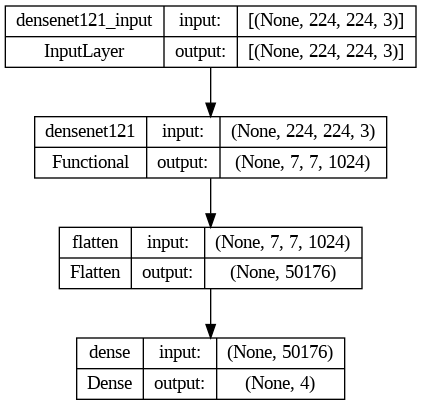

In [28]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [29]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0005),
    metrics=METRICS
)

In [30]:
callbacks = [
    ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
]

In [31]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=callbacks,
        verbose=1
    #  , class_weight=class_weights
)

Epoch 1/35
41/41 [==============================] - ETA: 0s - loss: 2.0499 - accuracy: 0.6223 - precision: 0.6317 - recall: 0.6162 - auc: 0.8408 - f1_score: 0.6223
Epoch 1: val_accuracy improved from -inf to 0.21393, saving model to best_model.keras
41/41 [==============================] - 106s 618ms/step - loss: 2.0499 - accuracy: 0.6223 - precision: 0.6317 - recall: 0.6162 - auc: 0.8408 - f1_score: 0.6223 - val_loss: 57.5069 - val_accuracy: 0.2139 - val_precision: 0.2139 - val_recall: 0.2139 - val_auc: 0.4760 - val_f1_score: 0.2139
Epoch 2/35
41/41 [==============================] - ETA: 0s - loss: 0.8291 - accuracy: 0.8578 - precision: 0.8602 - recall: 0.8563 - auc: 0.9613 - f1_score: 0.8578
Epoch 2: val_accuracy improved from 0.21393 to 0.48259, saving model to best_model.keras
41/41 [==============================] - 12s 285ms/step - loss: 0.8291 - accuracy: 0.8578 - precision: 0.8602 - recall: 0.8563 - auc: 0.9613 - f1_score: 0.8578 - val_loss: 9.2388 - val_accuracy: 0.4826 - val

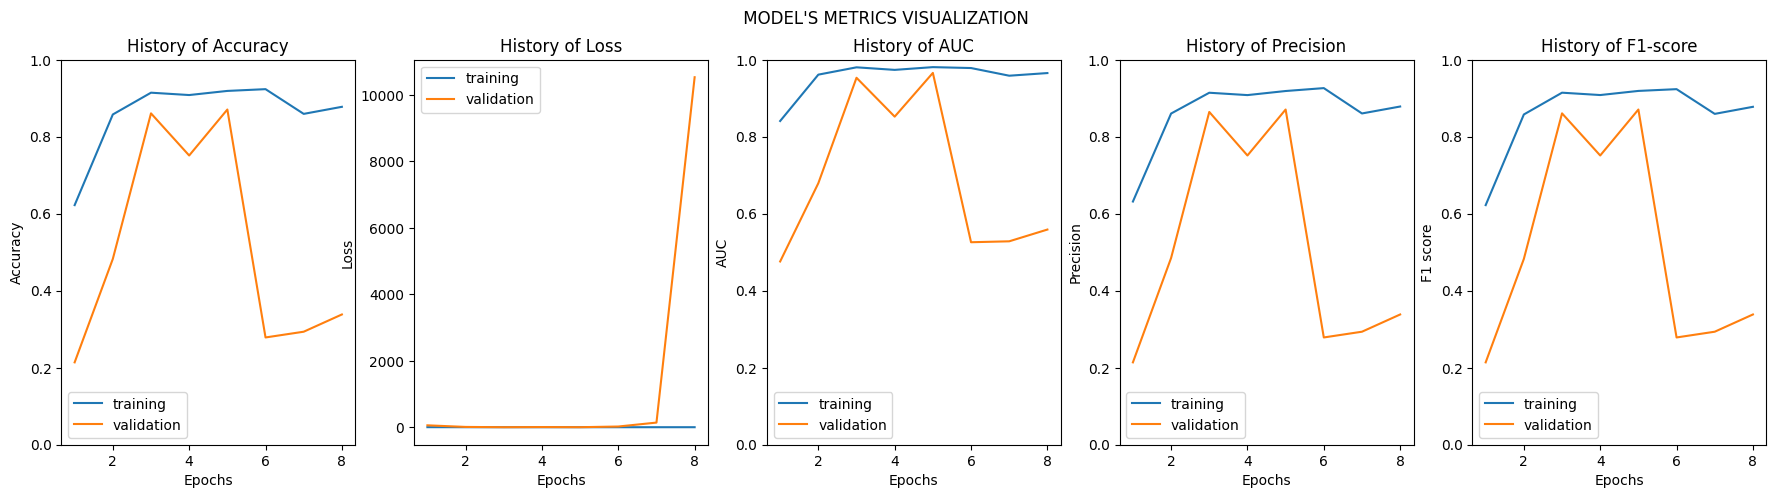

In [32]:
def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, f1, val_f1):

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(22, 5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    # Rescale the y-axis for accuracy, auc, precision, and f1
    rescale_factor = 0  # Adjust this factor to control the rescaling

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1.0])
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.set_ylim([rescale_factor, 1.0])
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.set_ylim([rescale_factor, 1.0])
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.set_ylim([rescale_factor, 1.0])
    ax5.legend(['training', 'validation'])

    plt.show()

# Example usage:
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss']
               ,
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['f1_score'], history.history['val_f1_score'])


In [33]:
model.evaluate(test_generator)

10/10 [==============================] - 3s 354ms/step - loss: 0.8561 - accuracy: 0.8414 - precision: 0.8472 - recall: 0.8414 - auc: 0.9516 - f1_score: 0.8414


[0.8561273813247681,
 0.8413792848587036,
 0.8472222089767456,
 0.8413792848587036,
 0.9515575766563416,
 0.8413792848587036]

In [34]:
# Load the test dataset
X_test, y_test = [], []
for i in range(len(validation_generator)):
    batch_X, batch_y = validation_generator[i]
    X_test.append(batch_X)
    y_test.append(batch_y)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the one-hot encoded true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Create a classification report
report = classification_report(y_true_classes, y_pred_classes)

print(report)

7/7 [==============================] - 6s 79ms/step
              precision    recall  f1-score   support

           0       0.84      0.85      0.85        68
           1       0.77      0.79      0.78        38
           2       0.86      1.00      0.92        43
           3       0.98      0.81      0.88        52

    accuracy                           0.86       201
   macro avg       0.86      0.86      0.86       201
weighted avg       0.87      0.86      0.86       201



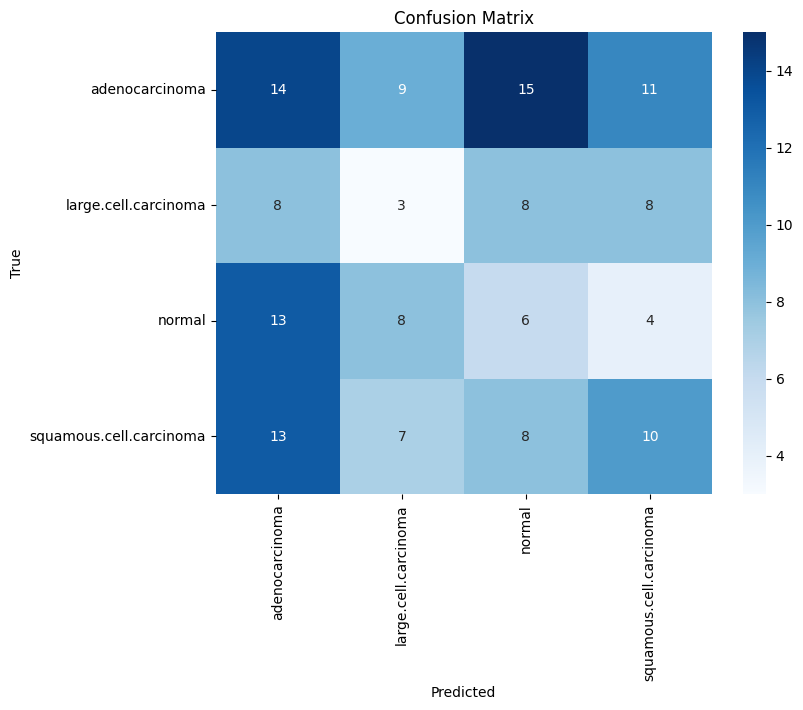

In [36]:

class_names = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
